# Plots for paper

In [1]:
using Pkg

# Uncomment below to update PartonDensity/BAT!
#Pkg.rm("PartonDensity")
#Pkg.add(url="https://github.com/cescalara/PartonDensity.jl.git")
#Pkg.rm("BAT")
#Pkg.add(url="https://github.com/bat/BAT.jl.git")

Pkg.instantiate()

┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/fran/projects/high-x-parton-pdf-inference/Manifest.toml:0
Precompiling project...
  ✓ GenericLinearAlgebra
  ✓ DoubleFloats
  ✓ BAT
  3 dependencies successfully precompiled in 38 seconds (270 already precompiled)


In [2]:
using BAT, Plots, PartonDensity, DelimitedFiles, StatsBase, Distributions, Printf
using LaTeXStrings, ValueShapes
import HDF5

gr(fmt=:png); 

Load data, results and set up parameters

In [3]:
# Data
counts_ep = readdlm("eP.dat") 
counts_em = readdlm("eM.dat")
nbins = length(counts_ep)

# Results
samples = bat_read("Data-Dirichlet-final.h5").result;

# As in PDF-fit-dirichlet.ipynb
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, 
                         spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();

Set up color scheme and aesthetic things

In [4]:
color_scheme = :viridis
font_family = "Computer Modern"
Plots.scalefontsizes()
Plots.scalefontsizes(1.2);
alpha = 0.6
prior_alpha = 0.2;

Until I figure out how to pass :viridis colours to BAT plotting routines...

In [5]:
c1 = :teal
c2 = :royalblue4
c3 = :midnightblue
c4 = :grey

:grey

## Figure 1

First, separate data out into unique $Q^2$ bins

In [6]:
q2_edges_all = Any[]
x_edges_all = Any[]
for i in 1:nbins
    (q2_edges, x_edges) = get_bin_info(i, quiet=true);
    push!(q2_edges_all, q2_edges)
    push!(x_edges_all, x_edges)
end

q2_edges_unique = copy(q2_edges_all)
n_q2_bins = length(unique!(q2_edges_unique))

# get x, counts for each q2 range
counts_em_qsel = Any[]
counts_ep_qsel = Any[]
x_values = Any[]
for q2r in 1:n_q2_bins
    bin_sel = findall(==(q2_edges_unique[q2r]), q2_edges_all)
    push!(counts_em_qsel, counts_em[bin_sel])
    push!(counts_ep_qsel, counts_ep[bin_sel])
    push!(x_values, [mean(_) for _ in x_edges_all[bin_sel]])
end

Now initialise and run the forward model for each sample

NB: Assumes SysErr version for all steps

In [7]:
Ns = 200 # Number of samples from posterior
sub_samples = BAT.bat_sample(samples, BAT.OrderedResampling(nsamples=Ns)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44


In [8]:
forward_model_init_sysErr(qcdnum_grid, qcdnum_params, splint_params)

counts_em_sampled = zeros(UInt64, (length(sub_samples), nbins))
counts_ep_sampled = zeros(UInt64, (length(sub_samples), nbins))
for s in eachindex(sub_samples)

    pdf_params_s = DirichletPDFParams(K_u=sub_samples.v.K_u[s], K_d=samples.v.K_d[s],
                                      λ_g1=sub_samples.v.λ_g1[s], 
                                      λ_g2=sub_samples.v.λ_g2[s],
                                      K_g=sub_samples.v.K_g[s], 
                                      λ_q=sub_samples.v.λ_q[s], 
                                      θ=Vector(sub_samples.v.θ[s]))
    
    par_errs_s = [sub_samples.v.beta0_1[s], sub_samples.v.beta0_2[s], 
                  sub_samples.v.beta0_3[s], sub_samples.v.beta0_4[s], 
                  sub_samples.v.beta0_4[s], sub_samples.v.beta0_5[s],
                  sub_samples.v.beta0_6[s], sub_samples.v.beta0_7[s], 
                  sub_samples.v.beta0_8[s]]
    
    counts_ep_pred_s, counts_em_pred_s = forward_model_sysErr(pdf_params_s,    
                                                              qcdnum_params, 
                                                              splint_params,
                                                              quark_coeffs, 
                                                              par_errs_s)
    
    for j in 1:nbins
        
        counts_ep_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta1[s]
        counts_em_pred_s[j] *= 1 + 0.018 * sub_samples.v.Beta2[s]
        
        counts_em_sampled[s, j] = rand(Poisson(counts_em_pred_s[j]))
        counts_ep_sampled[s, j] = rand(Poisson(counts_ep_pred_s[j]))
        
    end
    
end

  +---------------------------------------------------------------------+   
  |                                                                     |   
  |    If you use QCDNUM, please refer to:                              |   
  |                                                                     |   
  |    M. Botje, Comput. Phys. Commun. 182(2011)490, arXiV:1005.1481    |   
  |                                                                     |   
  +---------------------------------------------------------------------+   
  
  

 FILLWT: start unpolarised weight calculations
 Subgrids    3 Subgrid points   15   50   75
 Pij LO
 Pij NLO
 Pij NNLO
 Aij LO
 Aij NLO
 Aij NNLO
 FILLWT: weight calculations completed


 ZMFILLW: start weight calculations   4  38   0   0
 ZMFILLW: calculations completed

  +---------------------------------------+
  | You are using SPLINT version 20220308 |
  +---------------------------------------+


0.00019953
0.00016954
0.00019447
1.752500000000

In [9]:
# Use +2 to avoid lightest colors (not easy to see)
cmap = palette(color_scheme, n_q2_bins+2)

Make plot

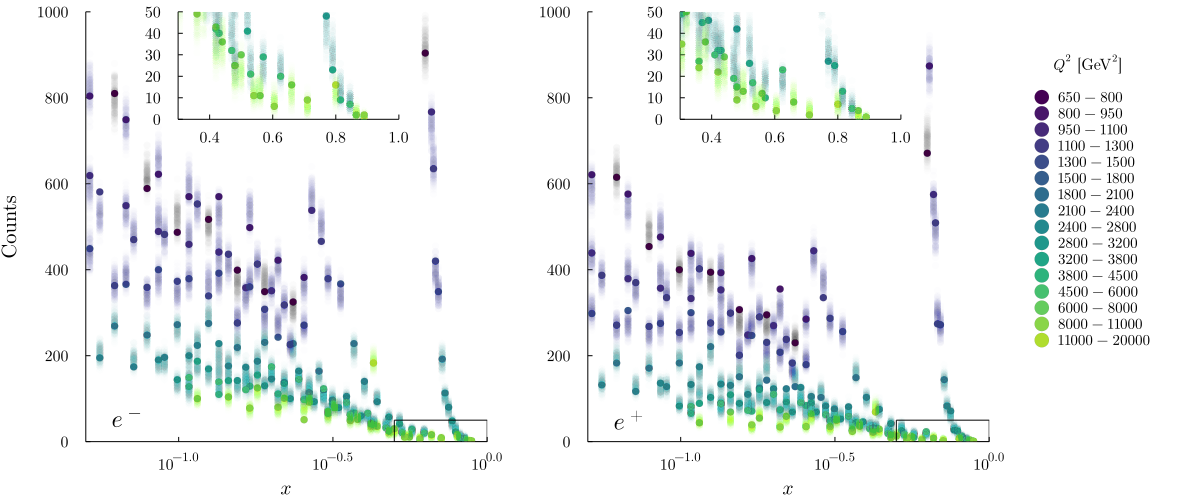

In [10]:
plot(framestyle=:axes, size=(1200, 500), fontfamily=font_family, 
    leftmargin=5Plots.mm, bottommargin=5Plots.mm, rightmargin=5Plots.mm,
    layout=@layout([a b c{0.15w}]),)

plot!(inset=(1, bbox(0.23, 0.75, 0.55, 0.25, :bottom)))
plot!(inset=(2, bbox(0.23, 0.75, 0.55, 0.25, :bottom)))

plot!(xlim=(5e-2, 1), ylim=(0, 1000), xlabel="\$x\$", ylabel="Counts", xscale=:log, 
    grid=false, legend=:false, foreground_color_legend=nothing,
    legendfontsize=10, thickness_scaling=1, xticks=[0.1, 10^-0.5, 1.0], subplot=1)
plot!(xlim=(5e-2, 1), ylim=(0, 1000), xlabel="\$x\$", ylabel="", xscale=:log, 
    grid=false, legend=false, xticks=[0.1, 10^-0.5, 1.0], subplot=2)

for sp in [4, 5]
    plot!(xlim=(0.3, 1.0), ylim=(0, 50), grid=false, subplot=sp)
end

# Data
for i in 1:n_q2_bins

    label = @sprintf "  \$%g - %g\$" q2_edges_unique[i][1] q2_edges_unique[i][2]

    # Main plots and inset plots
    scatter!(x_values[i], counts_em_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=0, subplot=1)
    scatter!(x_values[i], counts_ep_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=0, subplot=2)
    scatter!(x_values[i], counts_em_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=0, subplot=4)
    scatter!(x_values[i], counts_ep_qsel[i], label="", color=cmap[i], 
        markerstrokewidth=0, subplot=5)
    
    # For legend (invisible, trick to create space)
    scatter!(x_values[i], counts_em_qsel[i], label=label, color=cmap[i], 
        markerstrokewidth=0, subplot=3)

end

# Samples
for s in eachindex(sub_samples)
    
    counts_em_s = Any[]
    counts_ep_s = Any[]
    for q2r in 1:n_q2_bins
        bin_sel = findall(==(q2_edges_unique[q2r]), q2_edges_all)
        push!(counts_em_s, counts_em_sampled[s, bin_sel])
        push!(counts_ep_s, counts_ep_sampled[s, bin_sel])
    end
    
    for i in 1:n_q2_bins
        
        scatter!(x_values[i], counts_em_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=1)
        scatter!(x_values[i], counts_ep_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=2)
        scatter!(x_values[i], counts_em_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=4)
        scatter!(x_values[i], counts_ep_s[i], color=cmap[i], markerstrokewidth=0, 
            alpha=0.01, label="", subplot=5)
        
    end
    
end

# Draw box around zoomed region and connecting line
for sp in [1, 2]
    plot!([0.5, 0.5], [0, 50], color="black", linewidth=1, linestyle=:solid, 
        subplot=sp)
    plot!([1.0, 1.0], [0, 50], color="black", linewidth=1, linestyle=:solid, 
        subplot=sp)
    plot!([0.5, 1.0], [50, 50], color="black", linewidth=1, linestyle=:solid, 
        subplot=sp)
    plot!([0.5, 1.0], [0, 0], color="black", linewidth=1, linestyle=:solid, 
        subplot=sp)
end

plot!(legend=:left, foreground_color_legend=nothing, framestyle=:none,
    subplot=3, xlim=(1,2), ylim=(0, 1000), legendfontsize=10, thickness_scaling=1,
    left_margin=-10Plots.mm)
annotate!(1.4, 880, text("\$Q^2\$ [GeV\$^2\$]", 10, font_family), subplot=3)
annotate!(0.07, 50, text("\$e^-\$", 16, font_family), subplot=1)
p = annotate!(0.07, 50, text("\$e^+\$", 16, font_family), subplot=2)
p

Save figure - for some reason PDF messes up the colours - need to check.

In [11]:
savefig(p, "figures/fig1_data_space_v1.pdf")
savefig(p, "figures/fig1_data_space_v1.png")

## Figure 2

Joint posterior of $K_u$ and $\Delta_u$, with marginal views and comparison with the prior.

In [12]:
# Get some prior samples for plotting
prior = NamedTupleDist(
    θ = Dirichlet([34.,17.,22.,22.,2,2,1,1,0.5]),
    K_u = Truncated(Normal(3.5, 0.5), 2., 5.),
    K_d = Truncated(Normal(3.5, 0.5), 2., 5.),
    λ_g1 = Uniform(1., 2.),
    λ_g2 = Uniform(-0.5, -0.1),
    K_g =  Truncated(Normal(4., 1.5), 2., 5.),
    λ_q = Uniform(-0.5, -0.1),
    Beta1 =  Truncated(Normal(0, 1), -5, 5),
    Beta2 =  Truncated(Normal(0, 1), -5, 5),
    beta0_1=  Truncated(Normal(0, 1), -5, 5), 
    beta0_2=   Truncated(Normal(0, 1), -5, 5),    
    beta0_3= Truncated(Normal(0, 1), -5, 5), 
    beta0_4=  Truncated(Normal(0, 1), -5, 5), 
    beta0_5=  Truncated(Normal(0, 1), -5, 5), 
    beta0_6=  Truncated(Normal(0, 1), -5, 5), 
    beta0_7=  Truncated(Normal(0, 1), -5, 5), 
    beta0_8=   Truncated(Normal(0, 1), -5, 5)
);

prior_samples=bat_sample(prior).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44
┌ Info: Using sampling algorithm IIDSampling
│   nsamples: Int64 100000
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44


In [13]:
xlims_K_u = (2.0, 5.0) # (3.2, 4.4)
xlims_D_u = (0.2, 0.5) # (0.29, 0.37)
intervals = [0.68, 0.95]
labels = [L"~~\mathrm{Posterior}~68~\%", L"~~\mathrm{Posterior}~95~\%"]
prior_labels = [L"~~\mathrm{Prior}~68~\%", L"~~\mathrm{Prior}~95~\%"]
colors = [c3, c1]
prior_colors = [:grey40, :grey50]

2-element Vector{Symbol}:
 :grey40
 :grey50

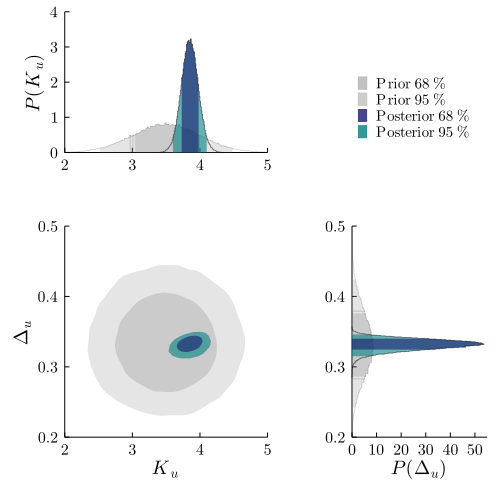

┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021
┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021


In [14]:
plot(framestyle=:axes, size=(500, 500), fontfamily=font_family, 
    layout=@layout([a b; c{0.6w, 0.6h} d]), grid=false)

# Joint posterior
plot!(prior_samples, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals_contourf, smoothing=4, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha,
    subplot=3)
plot!(samples, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals_contourf, smoothing=2, 
    marginalmode=false, intervals=intervals, fillcolors=reverse(colors), linewidth=0, alpha=alpha,
    subplot=3, xlims=xlims_K_u, ylims=xlims_D_u)

# K_u marginal
plot!(prior_samples, :K_u, legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals, 
    colors=prior_colors, subplot=1, alpha=prior_alpha)
plot!(samples, :K_u, legend=false, xlabel="", ylabel=L"P(K_u)", subplot=1, 
    xlims=xlims_K_u, ylims=(0, 4), seriestype=:smallest_intervals, 
    marginalmode=false, intervals=intervals, colors=colors, alpha=alpha)

# Delta_u marginal
plot!(prior_samples, :(θ[1]), legend=false, marginalmode=false, 
    seriestype=:smallest_intervals, intervals=intervals,
    colors=prior_colors, subplot=4, alpha=prior_alpha, 
    orientation=:horizontal)
plot!(samples, :(θ[1]), legend=false, ylabel="", xlabel=L"P(\Delta_u)", 
    subplot=4, ylims=xlims_D_u, xlims=(0, 55), 
    seriestype=:smallest_intervals, intervals=intervals, marginalmode=false, 
    colors=colors, alpha=alpha, orientation=:horizontal)

# Legend
plot!(prior_samples, (:(K_u), :(θ[1])), xlabel=L"K_u", ylabel=L"\Delta_u",
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, interval_labels=prior_labels, 
    colors=reverse(prior_colors), linewidth=0, 
    alpha=prior_alpha+0.2,
    subplot=2)
p = plot!(samples, (:(K_u), :(θ[1])),
    seriestype=:smallest_intervals,
    marginalmode=false, intervals=intervals, colors=reverse(colors), 
    interval_labels=labels,
    linewidth=0, alpha=alpha+0.2, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=2, xlims=(0, 1), ylims=(0, 0.1))

In [15]:
savefig(p, "figures/fig2_K_u_D_u_posterior.png")
savefig(p, "figures/fig2_K_u_D_u_posterior.pdf")

┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021
┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021
┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021
┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /Users/fran/.julia/packages/Plots/lW9ll/src/backends/gr.jl:2021


## Figure 3 & 4

Model space results and effective power of 1-x for u valence.

In [6]:
function wrap_xuval(p::NamedTuple, x::Real)
    
    pdf_p = DirichletPDFParams(K_u=p.K_u, K_d=p.K_d, λ_g1=p.λ_g1, 
                                    λ_g2=p.λ_g2, K_g=p.K_g, λ_q=p.λ_q, θ=p.θ)
    return PartonDensity.x_uv_x(x,pdf_p.λ_u, pdf_p.K_u)
end

function eff_power(p::NamedTuple, x::Real)
    return p.K_u-(1-x)*p.θ[1]*(p.K_u+1)/(2-p.θ[1])/x
end

x_grid = range(0, stop=1, length=200);

First with 3 credible regions...

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44


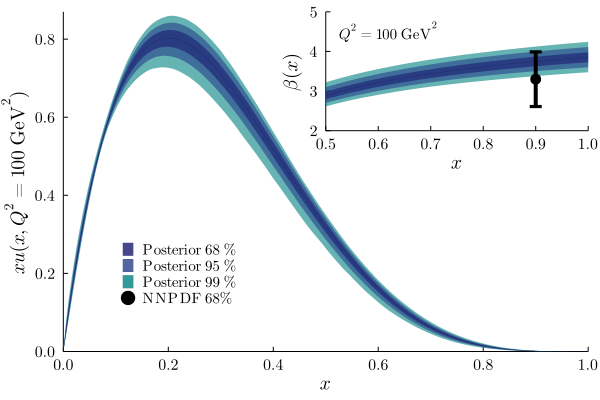

In [44]:
plot(framestyle=:axes, size=(500, 400), fontfamily=font_family, grid=false)

plot!(x_grid, wrap_xuval, samples, ylabel=L"xu(x,Q^2=100~\mathrm{GeV}^2)",
    global_mode=false, median=false, subplot=1, legend=false,
    xlims=(0, 1), ylims=(0, 0.87), colors=[c3, c2, c1], fillalpha=0.6, 
    linewidth=0, xlabel=L"x")

plot!(inset=(1, bbox(0.5, 0.65, 0.5, 0.35, :bottom)), grid=false)
plot!(0.5:0.01:1, eff_power, samples, subplot=2, legend=false, xlims=(0.5, 1), 
    ylims=(2.0, 5.0), ylabel=L"\beta(x)", xlabel=L"x",
    median=false, global_mode=false, linewidth=0, colors=[c3, c2, c1], fillalpha=0.6)
scatter!([0.9], [3.3], yerr=[0.69], subplot=2, markersize=6, msw=4, color="black")
annotate!(0.62, 4.5, text(L"Q^2=100~\mathrm{GeV}^2", 10, font_family), subplot=2)

plot!(inset=(1, bbox(0.1, 0.1, 0.3, 0.3, :bottom)), grid=false)
plot!(samples, (:(K_u), :(θ[1])),
    seriestype=:smallest_intervals,
    marginalmode=false, colors=[c1, c2, c3], 
    interval_labels=[L"~~\mathrm{Posterior}~68~\%",
        L"~~\mathrm{Posterior}~95~\%", L"~~\mathrm{Posterior}~99~\%"],
    linewidth=0, alpha=0.8, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=3, xlims=(0, 1), ylims=(0, 0.1))
scatter!([0.9], [3.3], yerr=[0.69], label=L"~~\mathrm{NNPDF}~68\%", color="black", msw=4, subplot=3)
p = plot!(subplot=3, framestyle=:none)

In [45]:
savefig(p, "figures/fig3_uval_model_space_3reg.png")
savefig(p, "figures/fig3_uval_model_space_3reg.pdf")

Now with only 2 credible regions:

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44


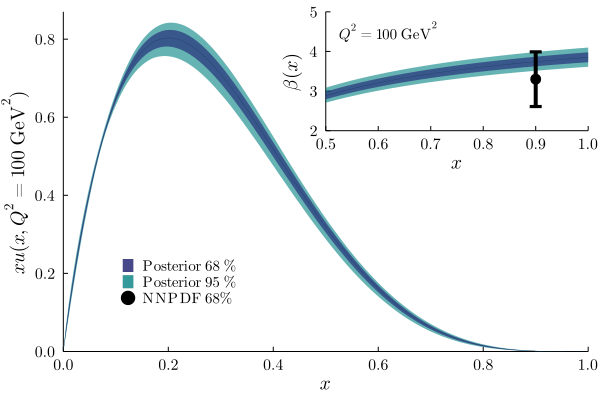

In [46]:
plot(framestyle=:axes, size=(500, 400), fontfamily=font_family, grid=false)

plot!(x_grid, wrap_xuval, samples, ylabel=L"xu(x,Q^2=100~\mathrm{GeV}^2)",
    global_mode=false, median=false, subplot=1, legend=false, conf_intervals=[0.68, 0.95],
    xlims=(0, 1), ylims=(0, 0.87), colors=[c3, c1], fillalpha=0.6, 
    linewidth=0, xlabel=L"x")

plot!(inset=(1, bbox(0.5, 0.65, 0.5, 0.35, :bottom)), grid=false)
plot!(0.5:0.01:1, eff_power, samples, subplot=2, legend=false, xlims=(0.5, 1), 
    ylims=(2, 5), ylabel=L"\beta(x)", xlabel=L"x", conf_intervals=[0.68, 0.95],
    median=false, global_mode=false, linewidth=0, colors=[c3, c1], fillalpha=0.6)
scatter!([0.9], [3.3], yerr=[0.69], subplot=2, markersize=6, msw=4, color="black")
annotate!(0.62, 4.5, text(L"Q^2=100~\mathrm{GeV}^2", 10, font_family), subplot=2)

plot!(inset=(1, bbox(0.1, 0.1, 0.3, 0.3, :bottom)), grid=false)
plot!(samples, (:(K_u), :(θ[1])),
    seriestype=:smallest_intervals,
    intervals=[0.68, 0.95],
    marginalmode=false, colors=[c1, c3], 
    interval_labels=[L"~~\mathrm{Posterior}~68~\%",
        L"~~\mathrm{Posterior}~95~\%", L"~~\mathrm{Posterior}~99~\%"],
    linewidth=0, alpha=0.8, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=3, xlims=(0, 1), ylims=(0, 0.1))
scatter!([0.9], [3.3], yerr=[0.69], label=L"~~\mathrm{NNPDF}~68\%", color="black", msw=4, subplot=3)
p = plot!(subplot=3, framestyle=:none)

In [47]:
savefig(p, "figures/fig3_uval_model_space_2reg.png")
savefig(p, "figures/fig3_uval_model_space_2reg.pdf")

Finally with one credible region:

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/fran/.julia/packages/BAT/PuvTK/src/algotypes/bat_default.jl:44


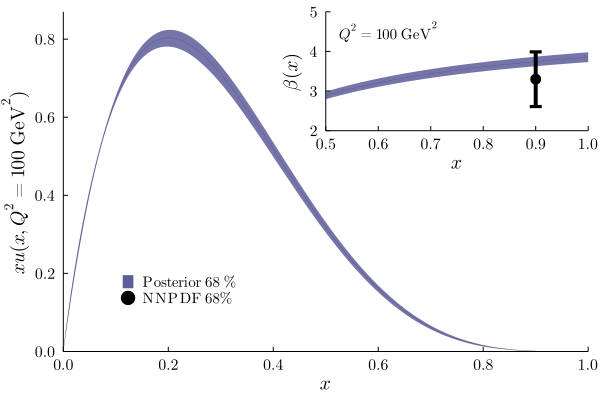

In [48]:
plot(framestyle=:axes, size=(500, 400), fontfamily=font_family, grid=false)

plot!(x_grid, wrap_xuval, samples, ylabel=L"xu(x,Q^2=100~\mathrm{GeV}^2)",
    global_mode=false, median=false, subplot=1, legend=false, conf_intervals=[0.68],
    xlims=(0, 1), ylims=(0, 0.87), colors=[c3], fillalpha=0.6, 
    linewidth=0, xlabel=L"x")

plot!(inset=(1, bbox(0.5, 0.65, 0.5, 0.35, :bottom)), grid=false)
plot!(0.5:0.01:1, eff_power, samples, subplot=2, legend=false, xlims=(0.5, 1), 
    ylims=(2, 5), ylabel=L"\beta(x)", xlabel=L"x", conf_intervals=[0.68],
    median=false, global_mode=false, linewidth=0, colors=[c3], fillalpha=0.6)
scatter!([0.9], [3.3], yerr=[0.69], subplot=2, markersize=6, msw=4, color="black")
annotate!(0.62, 4.5, text(L"Q^2=100~\mathrm{GeV}^2", 10, font_family), subplot=2)

plot!(inset=(1, bbox(0.1, 0.1, 0.3, 0.3, :bottom)), grid=false)
plot!(samples, (:(K_u), :(θ[1])),
    seriestype=:smallest_intervals,
    intervals=[0.68],
    marginalmode=false, colors=[c3], 
    interval_labels=[L"~~\mathrm{Posterior}~68~\%",
        L"~~\mathrm{Posterior}~95~\%", L"~~\mathrm{Posterior}~99~\%"],
    linewidth=0, alpha=0.7, legend=:bottomleft, foreground_color_legend=false,
    framestyle=:none, subplot=3, xlims=(0, 1), ylims=(0, 0.1))
scatter!([0.9], [3.3], yerr=[0.69], label=L"~~\mathrm{NNPDF}~68\%", color="black", msw=4, subplot=3)
p = plot!(subplot=3, framestyle=:none)

In [49]:
savefig(p, "figures/fig3_uval_model_space_1reg.png")
savefig(p, "figures/fig3_uval_model_space_1reg.pdf")